# visualization
편집자: MAI&CV lab 소속 오예인 (yeinoh36@gmail.com)

In [1]:
import argparse
import h5py
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import cv2

import openslide

## custom modules
# from dataset import EmbeddingDataset
# from transformer import Transformer

## 데이터 준비

In [6]:
# 패치에 해당하는 원본 복붙
import os

def get_subfolder_names(parent_folder):
    subfolder_names = [name for name in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, name))]
    return subfolder_names


parent_folder = '/data1/yein/data/TCGA_STAD_patches'
subfolder_names = get_subfolder_names(parent_folder)
print(subfolder_names)
print(len(subfolder_names))

['TCGA-R5-A804-01Z-00-DX1.D1DDC2EE-C3ED-4502-B1C1-71D5585E9470', 'TCGA-FP-8209-01Z-00-DX1.a5e13081-1631-44d4-8d6a-c229a22c2311', 'TCGA-BR-7716-01Z-00-DX1.777e570a-5771-4288-b110-26e44358745b', 'TCGA-VQ-A91Y-01Z-00-DX1.9401E1F3-4110-4F1E-99A0-36D4E1518650', 'TCGA-HU-8604-01Z-00-DX1.F358D894-D9C4-49BF-8B9F-F80DA11BBC5A', 'TCGA-BR-8364-01Z-00-DX1.245676db-6d78-4ae4-ae36-b4a70781a2f8', 'TCGA-HF-7136-01Z-00-DX1.F8C07BE3-06C7-4202-97C6-10B81D322A16', 'TCGA-D7-8579-01Z-00-DX1.BFA005CC-E2B4-4A36-9C84-5F51F0526856', 'TCGA-BR-8487-01Z-00-DX1.81ed3672-7b6c-4db4-9cba-3f0173709320', 'TCGA-CG-4443-01Z-00-DX1.484defba-273b-4683-9c32-883f3da8ba5f', 'TCGA-VQ-A8E3-01Z-00-DX1.2CEA9979-EC34-48E2-A092-55757506490A', 'TCGA-BR-8365-01Z-00-DX1.0cf05858-a4a5-468e-aa62-d3e3e91eab4a', 'TCGA-D7-A74B-01Z-00-DX1.F7A13A7F-2812-43D9-A101-E1BFEA8B3454', 'TCGA-VQ-A8DL-01Z-00-DX1.E720AE39-654E-4587-A294-2ED2BCE6F043', 'TCGA-VQ-A8PS-01Z-00-DX1.E93B2855-6350-4037-8C41-E781D887C790', 'TCGA-CG-4444-01Z-00-DX1.2f966933-a92c-

In [7]:
import shutil

def find_and_copy_svs_files(source_folder, target_folder, subfolder_names):
    for root, dirs, files in os.walk(source_folder):
        for file in files:
            if file.endswith('.svs'):
                file_name_without_ext = os.path.splitext(file)[0]
                if file_name_without_ext in subfolder_names:
                    source_file_path = os.path.join(root, file)
                    target_file_path = os.path.join(target_folder, file)
                    shutil.copy2(source_file_path, target_file_path)
                    print(f"Copied {file} to {target_folder}")

source_folder = '/data1/yumi/data/patho_/TCGA/STAD'
target_folder = '/data1/yein/data/TCGA_STAD_wsi'

# .svs 파일 찾고 복사하기
find_and_copy_svs_files(source_folder, target_folder, subfolder_names)

Copied TCGA-BR-8296-01Z-00-DX1.0f4638b7-a38e-41f8-96e0-3e3a72cd2c10.svs to /data1/yein/data/TCGA_STAD_wsi
Copied TCGA-BR-8364-01Z-00-DX1.245676db-6d78-4ae4-ae36-b4a70781a2f8.svs to /data1/yein/data/TCGA_STAD_wsi
Copied TCGA-FP-A9TM-01Z-00-DX1.1BD7C378-9FDD-46F0-B546-BB255079AFAA.svs to /data1/yein/data/TCGA_STAD_wsi
Copied TCGA-CG-4306-01Z-00-DX1.d4b89854-8529-4fb5-847a-ddb59b163727.svs to /data1/yein/data/TCGA_STAD_wsi
Copied TCGA-BR-7957-01Z-00-DX1.870e24e0-b9cf-4baa-91f1-bd031d06da8e.svs to /data1/yein/data/TCGA_STAD_wsi
Copied TCGA-CD-8535-01Z-00-DX1.ADD3D8B1-FECB-46C1-940B-7D261723D850.svs to /data1/yein/data/TCGA_STAD_wsi
Copied TCGA-VQ-A8DU-01Z-00-DX1.12DD8768-1315-472E-801D-F44A418BEA41.svs to /data1/yein/data/TCGA_STAD_wsi
Copied TCGA-CG-5724-01Z-00-DX1.89B75EBF-BF6E-418F-8FA7-F564055EE6DA.svs to /data1/yein/data/TCGA_STAD_wsi
Copied TCGA-IN-7806-01Z-00-DX1.2e7288fd-e149-4d4f-9d63-dd2e2f91d4f8.svs to /data1/yein/data/TCGA_STAD_wsi
Copied TCGA-CD-8528-01Z-00-DX1.DE29BA05-ABCB-4

In [9]:
import os

def get_file_names(parent_folder):
    file_names = [name for name in os.listdir(parent_folder) if os.path.isfile(os.path.join(parent_folder, name))]
    return file_names

parent_folder = '/data1/yein/data/TCGA_STAD_wsi'
file_names = get_file_names(parent_folder)
print(file_names)
print(len(file_names))

['TCGA-BR-6566-01Z-00-DX1.908c1c0f-12a4-4fa8-a398-ca3b033e7496.svs', 'TCGA-IN-7808-01Z-00-DX1.0aacd7e2-1454-4aa4-866b-b142fa04e619.svs', 'TCGA-BR-4187-01Z-00-DX1.5358ef4f-c9af-40d4-b366-48876a8503cc.svs', 'TCGA-CG-4460-01Z-00-DX1.498845d6-e330-45d7-a5ac-153f2cf9b3c7.svs', 'TCGA-CG-4455-01Z-00-DX1.f695a661-323d-4aeb-a3db-72510719eeed.svs', 'TCGA-HU-A4G6-01Z-00-DX1.83F4504C-B632-4B15-9978-A007C2118563.svs', 'TCGA-D7-6527-01Z-00-DX2.AC6B9D7B-E289-449C-934B-E15BD593CED4.svs', 'TCGA-D7-8578-01Z-00-DX1.902BBFC1-2456-4718-9A5E-2FD9AE47AF44.svs', 'TCGA-D7-6524-01Z-00-DX2.6E8242FF-FAF3-4CAA-9CB2-CE0BC1D518C9.svs', 'TCGA-D7-6822-01Z-00-DX2.4085F597-DD0C-4793-9586-CCC73382986B.svs', 'TCGA-D7-A4YX-01Z-00-DX1.54DE426E-7EC0-4FF4-919F-045E38B3C34E.svs', 'TCGA-CG-4443-01Z-00-DX1.484defba-273b-4683-9c32-883f3da8ba5f.svs', 'TCGA-FP-7829-01Z-00-DX1.22253191-e487-46f6-b743-d7c44ad01f4c.svs', 'TCGA-D7-A4YY-01Z-00-DX1.D1623D77-0BBA-4CB6-97DC-382BE136A583.svs', 'TCGA-BR-6706-01Z-00-DX1.8627a957-8d44-47ec-915

## 특징 추출

In [2]:
import os
import h5py
from torchvision import models, transforms
from PIL import Image
import torch
import numpy as np

/home/yein/anaconda3/envs/py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
device = torch.device("cuda:2")
# torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ResNet50 모델 초기화
model = models.resnet50(pretrained=True).to(device)
model.eval()

# 이미지 전처리 파이프라인
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/home/yein/anaconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yein/anaconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# 루트 디렉토리 설정
root_dir = "/data1/yein/data/TCGA_STAD_patches"
output_dir = "/data1/yein/data/TCGA_STAD_features"

# 출력 디렉토리가 존재하지 않으면 생성
os.makedirs(output_dir, exist_ok=True)

# 슬라이드 단위로 처리
for slide_name in os.listdir(root_dir):
    slide_path = os.path.join(root_dir, slide_name)
    if not os.path.isdir(slide_path):  # 슬라이드 이름 폴더가 아닌 경우 건너뛰기
        continue

    # HDF5 파일 생성
    output_h5_path = os.path.join(output_dir, f"{slide_name}.h5")
    with h5py.File(output_h5_path, "w") as h5_file:
        # HDF5 데이터셋 초기화
        features = []
        filenames = []

        # 슬라이드 내 패치 파일 순회
        for patch_file in os.listdir(slide_path):
            if patch_file.endswith(".png"):
                patch_path = os.path.join(slide_path, patch_file)
                
                # 파일 이름에서 좌표 추출 (예: 3072_47104_2302_0.png)
                x, y, *_ = patch_file.split('_')
                filenames.append(f"{x}_{y}")

                # 이미지 로드 및 전처리
                img = Image.open(patch_path).convert("RGB")
                input_tensor = preprocess(img).unsqueeze(0).to(device)

                # ResNet50로 특징 벡터 추출
                with torch.no_grad():
                    feature = model(input_tensor).cpu().numpy()
                features.append(feature.squeeze())  # (2048,) 벡터 추가

        # HDF5에 저장
        h5_file.create_dataset("features", data=np.array(features))
        h5_file.create_dataset("filenames", data=np.array(filenames, dtype="S"))


KeyboardInterrupt: 

: 

In [1]:
import os

def get_file_names(parent_folder):
    file_names = [name for name in os.listdir(parent_folder) if os.path.isfile(os.path.join(parent_folder, name))]
    return file_names

parent_folder = '/data1/yein/data/TCGA_STAD_features'
file_names = get_file_names(parent_folder)
print(file_names)
print(len(file_names))

"""
GPU 문제로 408개에서 kill
"""

['TCGA-HU-A4GX-01Z-00-DX1.0F1A15D3-2C6A-4F16-8D9D-CF44179AB161.h5', 'TCGA-CD-8535-01Z-00-DX1.ADD3D8B1-FECB-46C1-940B-7D261723D850.h5', 'TCGA-HF-A5NB-01Z-00-DX1.CA67064B-3281-4144-A2A2-E0BC43E6F8D6.h5', 'TCGA-B7-5816-01Z-00-DX1.1B05F96A-D5E2-4366-A098-A861313F3461.h5', 'TCGA-CG-4304-01Z-00-DX1.65e18165-6009-4820-bed2-23c43baa2495.h5', 'TCGA-D7-A6EY-01Z-00-DX1.7E101F3B-8923-4554-AA48-C2493D0F46C0.h5', 'TCGA-BR-4366-01Z-00-DX1.1b5b7fce-bfbb-461d-9381-30eb37698b9e.h5', 'TCGA-CG-4469-01Z-00-DX1.005fafe8-ec9e-4283-95e4-f3cea0ac2365.h5', 'TCGA-BR-A4J7-01Z-00-DX1.95C74F68-FA18-446D-934D-296D9215D500.h5', 'TCGA-BR-4371-01Z-00-DX1.b45af289-5e56-40dd-80ba-7b8752d0344e.h5', 'TCGA-BR-4363-01Z-00-DX1.d2121987-481e-4f39-8cb3-724a9fc18036.h5', 'TCGA-CD-8525-01Z-00-DX1.37FFDBE4-8C18-4645-BFA3-139766A09601.h5', 'TCGA-VQ-A91E-01Z-00-DX1.BF3BA276-5A18-4B45-881D-4523C42B5AD8.h5', 'TCGA-D7-6525-01Z-00-DX2.1784F199-7F06-45BB-892A-EFB9009275EB.h5', 'TCGA-VQ-A8P2-01Z-00-DX1.0515199A-B84D-4973-ACAB-30B919F99FB8

## 시각화

In [3]:
feature_path = '/data1/yein/data/TCGA_STAD_features/TCGA-3M-AB46-01Z-00-DX1.70F638A0-BDCB-4BDE-BBFE-6D78A1A08C5B.h5'
slide_path = '/data1/yein/data/TCGA_STAD_wsi/TCGA-3M-AB46-01Z-00-DX1.70F638A0-BDCB-4BDE-BBFE-6D78A1A08C5B.svs'

h5_file = h5py.File(feature_path)
features = torch.Tensor(np.array(h5_file['features'])).unsqueeze(0)
name = np.array(h5_file['filenames'])

coords = []
for item in name:
    x, y, *_ = item.decode().split('_')
    coords.append((int(x), int(y)))
coords = torch.Tensor(coords)
coords = [(coords[i, 0].int().item(), coords[i, 1].int().item()) for i in range(coords.shape[0])]

slide = openslide.open_slide(slide_path)
level = len(slide.level_downsamples) - 1
d = slide.level_downsamples[level]
image = slide.read_region((0, 0), level, slide.level_dimensions[level])
image = np.array(image.convert("RGB"))

In [5]:
from model.HistoBistro.models.aggregators.transformer import Transformer

model = Transformer(input_dim=768, num_classes=2)
model.load_state_dict(torch.load('/data1/yein/model/HistoBistro/CancerCellCRCTransformer/trained_models/MSI_high_CRC_model.pth'), strict=False)
model.eval()

Transformer(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
  )
  (mlp_head): Sequential(
    (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=512, out_features=2, bias=True)
  )
  (transformer): TransformerBlocks(
    (layers): ModuleList(
      (0-1): 2 x ModuleList(
        (0): PreNorm(
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (1): PreNorm(
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): GELU(approximate='none')
        

### load utils

In [6]:
# function that plots scores nicely. scores should have the same length as the number of tiles.
def NormalizeData(data):
    return (data - data.min()) / (data.max() - data.min())

def plot_scores(coords, scores, image, overlay=True, clamp=0.05, norm=True, colormap='RdBu', crop=False, indices=[]):
    if clamp:
        q05, q95 = torch.quantile(scores, clamp), torch.quantile(scores, 1-clamp)
        scores.clamp_(q05,q95)
    
    if norm:
        scores = NormalizeData(scores)
        
    if crop:
        coords_min, coords_max = np.array(coords).min(axis=0), np.array(coords).max(axis=0)
        y_min, y_max, x_min, x_max = round(coords_min[1]/d), round(coords_max[1]/d), round(coords_min[0]/d), round(coords_max[0]/d)
        # if slide_path.stem == '439042':
        #     x_max = round((69 * 1013)/d)
        # print(y_min, y_max, x_min, x_max)
    else:
        y_min, y_max, x_min, x_max = 0, image.shape[0], 0, image.shape[1]
        
        
    attention_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)    
    tissue_map = -np.ones((image.shape[0], image.shape[1]), dtype=np.float32)
    
    offset = 2100
    for (x,y), s in zip(coords, scores):
        
        if colormap == 'RdBu': 
            attention_map[round(y/d):round((y+offset)/d), round(x/d):round((x+offset)/d)] = 1 - s.item()
        else: 
            attention_map[round(y/d):round((y+offset)/d), round(x/d):round((x+offset)/d)] = s.item()
        tissue_map[round(y/d):round((y+offset)/d), round(x/d):round((x+offset)/d)] = s.item()
       
    attention_map = np.array(attention_map * 255., dtype=np.uint8)
    tissue_map[tissue_map>=0] = 1
    tissue_map[tissue_map<0] = 0

    if len(indices) != 0:
        highlight_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)    
        for i in indices:
            x, y = coords[i]
            highlight_map[round(y/d):round((y+offset)/d), round(x/d):round((x+offset)/d)] = 1    
                 
#     plt.figure(figsize=(30, 30))
    a = 1.
    if overlay:
        plt.imshow(image[y_min:y_max, x_min:x_max])
        a = 0.5
    
    if crop:
        plt.imshow(attention_map[y_min:y_max, x_min:x_max], alpha=a*(tissue_map[y_min:y_max, x_min:x_max]), cmap=colormap, interpolation='nearest')
#         plt.imshow(attention_map[round(coords_min[1]/d):, round(coords_min[0]/d):], alpha=a*(tissue_map[round(coords_min[1]/d):, round(coords_min[0]/d):]), cmap=colormap, interpolation='nearest')
    else:
        plt.imshow(attention_map, alpha=a*(tissue_map), cmap=colormap, interpolation='nearest')
    
    if len(indices) != 0:
        plt.imshow(highlight_map[y_min:y_max, x_min:x_max], alpha=1.*(highlight_map), cmap='viridis', interpolation='nearest')
    
    plt.axis('off')

In [7]:
def compute_rollout_attention(all_layer_matrices, start_layer=0):
    # adding residual consideration- code adapted from https://github.com/samiraabnar/attention_flow
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = torch.eye(num_tokens).expand(batch_size, num_tokens, num_tokens).to(all_layer_matrices[0].device)
    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    matrices_aug = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
                          for i in range(len(all_layer_matrices))]
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer+1, len(matrices_aug)):
        joint_attention = matrices_aug[i].bmm(joint_attention)
    return joint_attention

def generate_rollout(model, input, start_layer=0):
    model(input)
    blocks = model.transformer.layers
    all_layer_attentions = []
    for blk in blocks:
        attn_heads = blk[0].fn.get_attention_map()
        avg_heads = (attn_heads.sum(dim=1) / attn_heads.shape[1]).detach()
        all_layer_attentions.append(avg_heads)
    rollout = compute_rollout_attention(all_layer_attentions, start_layer=start_layer)
    return rollout[:,0, 1:]

### 1) compute attention score

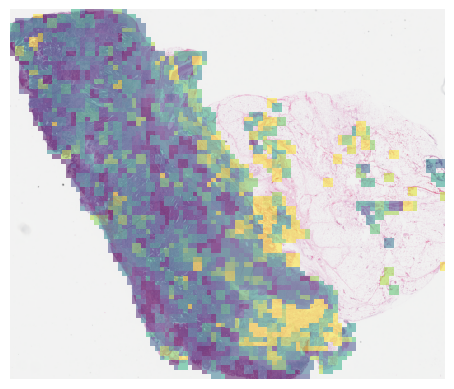

In [12]:
rollout = generate_rollout(model, features, start_layer=0).squeeze(0)

plot_scores(coords, rollout, image, overlay=True, colormap='viridis', crop=True)
plt.show()

### 2) compute class score

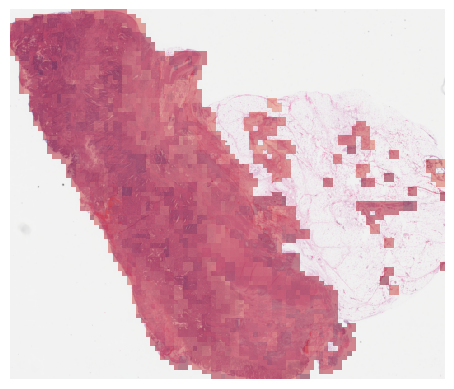

In [13]:
n = features.shape[1]
scores = np.zeros(n)

for i in range(n):
    out = model(features[:, i:i+1, :]).squeeze(0)
    probs = torch.softmax(out, dim=0)
    scores[i] = probs[1]
    # scores[i] = torch.sigmoid(out).item()  # Use the first element of out and convert to a Python scalar

plot_scores(coords, scores, image, overlay=True, colormap='RdBu_r', clamp=False, norm=False, crop=True)
plt.show()

### 3) compute attention x class score

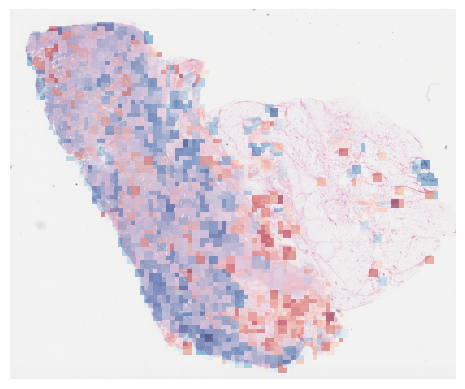

In [14]:
plot_scores(coords, rollout * scores, image, overlay=True, colormap='RdBu_r', clamp=False, norm=True)
plt.show()